In [ ]:
!pip install gitpython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
import os
import subprocess
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from git import Repo
from pathlib import Path
import requests, zipfile, io
import shutil

In [ ]:
#if using google colab
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/gdrive')
downloads_path = '/content/gdrive/MyDrive/Phantom_IAD_inputs'

#if using jupyter specify local path below
# downloads_path = str(Path.home()/'Downloads'/'Phantom_IAD_inputs')

if os.path.isdir(downloads_path):
    pass
else:
    Repo.clone_from("https://github.com/anishabahl/Phantom_IAD_inputs.git", downloads_path)
test_num_folders = [f for f in os.listdir(downloads_path) if os.path.isdir(downloads_path + '/' + f)]
#if no more than .git glass and no_glass folders present then download software
if len(test_num_folders) <= 3:
    #Download IAD software versions 3.11.4 and 3.11.6
    #if google colab or linux
    v1_path = 'https://github.com/scottprahl/iad/archive/refs/tags/v3.11.4.zip'
    v2_path = 'https://github.com/scottprahl/iad/archive/refs/tags/v3.11.6.zip'

    #if jupyter notebook or windows
    # v1_path = 'https://github.com/scottprahl/iad/releases/download/v3.11.4/iad-win-3-11-4.zip'
    # v2_path = 'https://github.com/scottprahl/iad/releases/download/v3.11.6/iad-win-3-11-6.zip'

    r1 = requests.get(v1_path)
    z1 = zipfile.ZipFile(io.BytesIO(r1.content))
    z1.extractall(downloads_path)
    test_num_folders_2 = [f for f in os.listdir(downloads_path) if os.path.isdir(downloads_path + '/' + f)]
    v1_folder_name = [f for f in test_num_folders_2 if f not in test_num_folders][0]
    #if google colab or linux
    subprocess.run(['chmod', '755', '-R', str(downloads_path)+'/'+str(v1_folder_name)])
    subprocess.run(['sudo', 'make'], cwd=downloads_path+'/'+v1_folder_name, check=True)

    print(v1_folder_name + ' Downloaded')
    v1_folder_name
    r2 = requests.get(v2_path)
    z2 = zipfile.ZipFile(io.BytesIO(r2.content))
    z2.extractall(downloads_path)
    test_num_folders_3 = [f for f in os.listdir(downloads_path) if os.path.isdir(downloads_path + '/' + f)]
    v2_folder_name = [f for f in test_num_folders_3 if f not in test_num_folders_2][0]
    #if google colab or linux
    subprocess.run(['chmod', '755', '-R', str(downloads_path)+'/'+str(v2_folder_name)])
    subprocess.call(['make', 'install'], cwd=downloads_path+'/'+v2_folder_name)

    print(v2_folder_name + ' Downloaded')
else:
    v1_folder_name, v2_folder_name = [f for f in sorted(os.listdir(downloads_path)) if os.path.isdir(downloads_path+'/'+f) and f[:3] =='iad']
    print('I found IAD versions '+v1_folder_name+' and '+v2_folder_name)
if not os.path.exists(downloads_path+'/'+v1_folder_name+'/inputs'):
    os.makedirs(downloads_path+'/'+v1_folder_name+'/inputs')
if not os.path.exists(downloads_path+'/'+v2_folder_name+'/inputs'):
    os.makedirs(downloads_path+'/'+v2_folder_name+'/inputs')


rm: cannot remove '/content/gdrive/MyDrive/Phantom_IAD_inputs': No such file or directory
Drive not mounted, so nothing to flush and unmount.
Mounted at /content/gdrive
iad-3.11.4 Downloaded
iad-3.11.6 Downloaded


In [ ]:
def convert_spectrometer_measurements_to_IAD_inputs(input_path, output_path, anisotropy=None, sample_n=1.41, glass='ON'):
    rfiles = [f for f in sorted(os.listdir(input_path+'reflectance/')) if f.endswith('Mean.Raw.csv')] #Assumes files are named the same in reflectance and transmittance folders so only collect reflectance files
    if glass == 'ON':
        glass_n = 1.5
        glass_d = 1.0
    elif glass == 'OFF':
        glass_n = 1.0
        glass_d = 0.0

    if anisotropy == None:
        anisotropy = 0.9

    for i in range(len(rfiles)):
        reflectance = np.genfromtxt(input_path+'reflectance/'+rfiles[i], delimiter=',')
        reflectance = np.delete(reflectance, 0, 0)
        transmittance = np.genfromtxt(input_path + 'transmittance/' + rfiles[i], delimiter=',')
        transmittance = np.delete(transmittance, 0, 0)

        filetext = \
        'IAD1\n' +\
        '#\n' +\
        '# Tests using calculated values for M_R and M_T\n'+\
        '# by Scott Prahl\n'+\
        '#\n'+\
        str(sample_n)+'  # Index of refraction of sample\n'+\
        str(glass_n) + '  # Index of refraction of top slide\n'+\
        '2.65  # [mm] Thickness of sample\n'+\
        str(glass_d) + '  # [mm] Thickness of slides\n'+\
        '10.0  # [mm] Diameter of illumination beam \n'+\
        '0.98  # Reflectance of calibration standard\n'+\
        '1  # [mm] Number of spheres used during each measurement\n'+\
        '# Reflection sphere properties (unused because n_spheres=0)\n'+\
        '100.0  # [mm] Sphere Diameter\n'+\
        '21.8  # [mm] Sample Port Diameter\n'+\
        '18.3  # [mm] Entrance Port Diameter\n'+\
        '8.0  # [mm] Detector Port Diameter\n'+\
        '0.98  # Reflectivity of the sphere wall\n'+\
        '# Transmission sphere properties (unused because n_spheres=0)\n'+\
        '100.0  # [mm] Sphere Diameter\n'+\
        '18.3  # [mm] Sample Port Diameter\n'+\
        '0.0  # [mm] Entrance Port Diameter\n'+\
        '8.0  # [mm] Detector Port Diameter\n'+\
        '0.98  # Reflectivity of the sphere wall\n'+\
        '2  # [mm] Number of measurements\n'+\
        '# M_R M_T \n'
        for j in range(reflectance.shape[0]):
            filetext += str(reflectance[j, 0]) + ' ' + str(reflectance[j, 1]/100) + ' ' + str(transmittance[j, 1]/100) + ' #' + str(anisotropy) +'\n'
        f = open(output_path + rfiles[i][:-4] + '.rxt', 'w')
        f.write(filetext)
        f.close()

def run_IAD(software_path, anisotropy=None):
    files = [f for f in sorted(os.listdir(software_path+'inputs/')) if f.endswith('.rxt')]
    if anisotropy == None:
        anisotropy = [0.9, ]*len(files)
    for count, i in enumerate(files):
        print('Processing ', i)
        #Unfortunately cannot get to work when specifying location of output files so files are all given same name to be overwritten whenever run
        #if google colab or linux
        subprocess.run(['chmod', '755', '-R', str(software_path)], check=True)
        subprocess.call(["./iad", '-X', '-i 8', '-V 2', '-g '+str(anisotropy[count]), 'inputs/'+str(i)], cwd=software_path)
        #if jupyter
        # subprocess.run(["iad", '-X', '-i 8', '-V 2', '-g '+str(anisotropy[count]), 'inputs/'+str(i)], shell=True, cwd=software_path)

        print('Finished processing ', i)


In [ ]:
def match_x(x1, x2, y2):
    """
    Interpolates spectrum2 to match the xaxis of spectrum1
    """
    x1 = x1.reshape((x1.shape[0], 1))
    x2 = x2.reshape((x2.shape[0], 1))
    y2 = y2.reshape((y2.shape[0], 1))
    spectrum2 = np.hstack((x2, y2))
    sorted1 = sorted(x1)
    sorted2 = spectrum2[np.argsort(spectrum2[:, 0])]
    new2 = np.zeros((x1.shape[0], 2))
    new2[:, 0] = np.array(sorted1).reshape(len(sorted1), )
    g = interp1d(sorted2[:, 0], sorted2[:, 1], fill_value="extrapolate")
    # g = interp1d(sorted2x, sorted2y, fill_value='extrapolate')
    new2[:, 1] = g(new2[:, 0])
    return new2

def plot_parameters(path_to_file, labelname=''):
    data = np.genfromtxt(path_to_file, skip_header=44, delimiter='	')
    data = np.delete(data, -1, 1)

    mu_a_phantom_ground_truth = np.array([0.18, 0.18, 0.16, 0.15, 0.15, 0.19])
    wavelength_phantom_ground_truth = np.array([480, 635, 690, 785, 830, 1000])
    mu_sp_phantom_ground_truth = np.array([36.1, 27.6, 23.5, 20.7, 18.7, 14.8])

    plt.figure('mu_a')
    plt.plot(data[:, 0], 10*data[:, -3], label='From IAD '+labelname)
    plt.scatter(wavelength_phantom_ground_truth, mu_a_phantom_ground_truth, label='ground truth', color='k')
    plt.xlabel('wavelength / nm')
    plt.ylabel('mu_a / cm-1')
    plt.legend(loc='best')
    plt.figure('mu_sp')
    plt.plot(data[:, 0], 10*data[:, -2], label='From IAD '+labelname)
    plt.scatter(wavelength_phantom_ground_truth, mu_sp_phantom_ground_truth, label='ground truth', color='k')
    plt.xlabel('wavelength / nm')
    plt.ylabel('mu_sp / cm-1')
    plt.legend(loc='best')

    mu_a_matched = match_x(wavelength_phantom_ground_truth, data[:, 0], 10*data[:, -3])[:, 1]
    mu_a_percent = 100*(mu_a_matched - mu_a_phantom_ground_truth)/mu_a_phantom_ground_truth
    plt.figure('mu_a_percentage_errors')
    plt.plot(wavelength_phantom_ground_truth, mu_a_percent, label=labelname)
    plt.xlabel('wavelengths / nm')
    plt.ylabel('Percentage error of mu_a from IAD vs ground truth / %')
    plt.legend(loc='best')

    mu_sp_matched = match_x(wavelength_phantom_ground_truth, data[:, 0], 10*data[:, -2])[:, 1]
    mu_sp_percent = 100 * (mu_sp_matched - mu_sp_phantom_ground_truth) / mu_sp_phantom_ground_truth
    plt.figure('mu_sp_percentage_errors')
    plt.plot(wavelength_phantom_ground_truth, mu_sp_percent, label=labelname)
    plt.xlabel('wavelengths / nm')
    plt.ylabel('Percentage error of mu_sp from IAD vs ground truth / %')
    plt.legend(loc='best')

def plot_IAD_outputfitted_v_inputmeasured(path_to_output, labelname=''):
    data = np.genfromtxt(path_to_output, skip_header=44, delimiter='	')
    data = np.delete(data, -1, 1)
    plt.figure('Total reflectance IAD output')
    plt.plot(data[:, 0], data[:, 1], label='Measured R '+labelname)
    plt.plot(data[:, 0], data[:, 2], label='Fitted R '+labelname)
    plt.xlabel('wavelength / nm')
    plt.ylabel('Reflectance / %')
    plt.legend(loc='best')
    plt.figure('Diffuse transmittance IAD output')
    plt.plot(data[:, 0], data[:, 3], label='Measured T '+labelname)
    plt.plot(data[:, 0], data[:, 4], label='Fitted T '+labelname)
    plt.xlabel('wavelength / nm')
    plt.ylabel('T / %')
    plt.legend(loc='best')

Processing  phantom.Mean.Raw.rxt
Finished processing  phantom.Mean.Raw.rxt
Processing  phantom.Mean.Raw.rxt
Finished processing  phantom.Mean.Raw.rxt


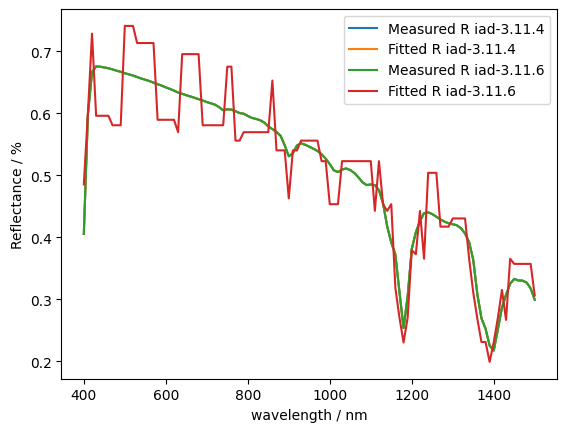

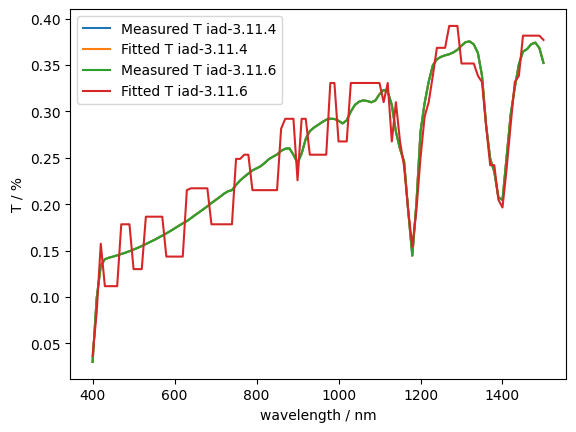

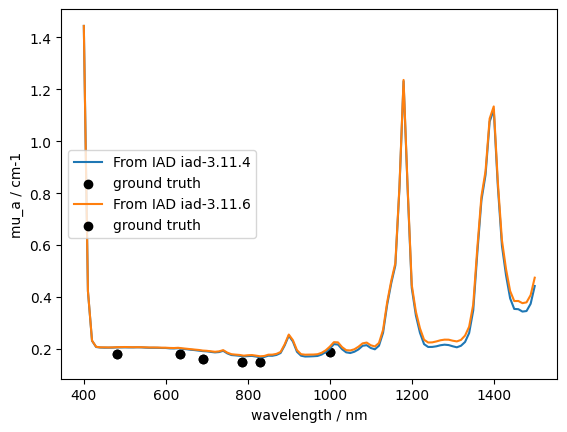

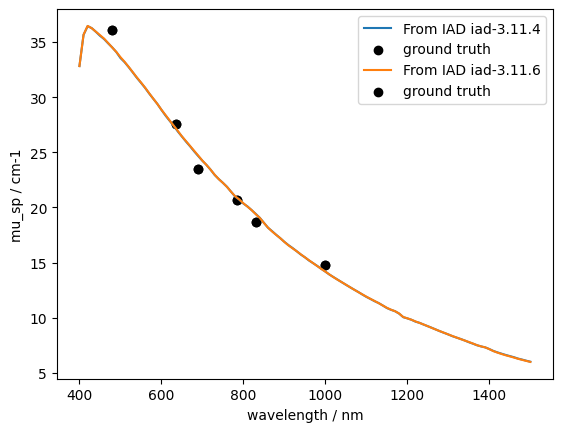

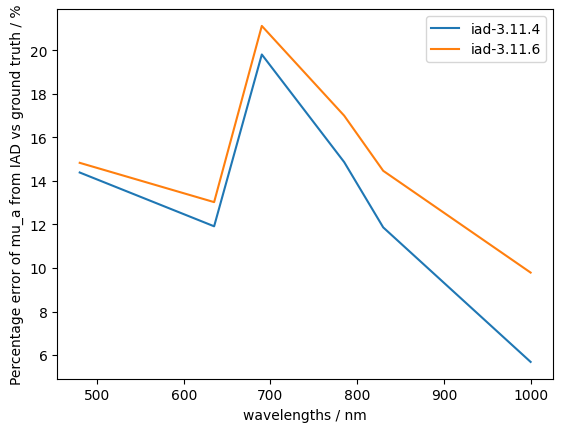

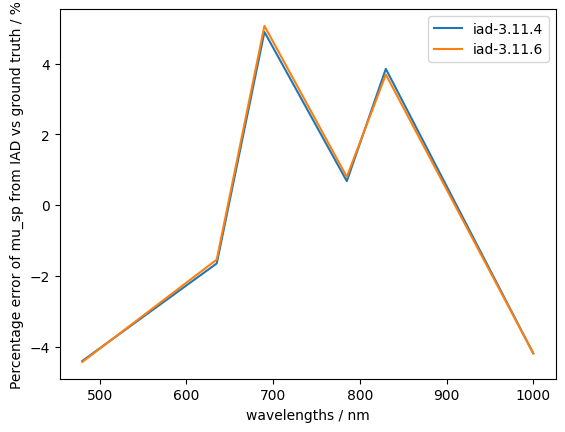

In [ ]:
#Comparing windows 3.11.4 to 3.11.6 using phantom without slides data
path_to_data = downloads_path+'/no_glass/'
#3.11.4
convert_spectrometer_measurements_to_IAD_inputs(path_to_data, downloads_path+'/'+v1_folder_name+'/inputs/', anisotropy=0.9, sample_n=1.41, glass='OFF')
run_IAD(downloads_path+'/'+v1_folder_name+'/', anisotropy=[0.9, ])
plot_IAD_outputfitted_v_inputmeasured(downloads_path+'/'+v1_folder_name+'/inputs/phantom.Mean.Raw.txt', labelname=v1_folder_name)
plot_parameters(downloads_path+'/'+v1_folder_name+'/inputs/phantom.Mean.Raw.txt', labelname=v1_folder_name)
#3.11.6
convert_spectrometer_measurements_to_IAD_inputs(path_to_data, downloads_path+'/'+v2_folder_name+'/inputs/', anisotropy=0.9, sample_n=1.41, glass='OFF')
run_IAD(downloads_path+'/'+v2_folder_name+'/', anisotropy=[0.9, ])
plot_IAD_outputfitted_v_inputmeasured(downloads_path+'/'+v2_folder_name+'/inputs/phantom.Mean.Raw.txt', labelname=v2_folder_name)
plot_parameters(downloads_path+'/'+v2_folder_name+'/inputs/phantom.Mean.Raw.txt', labelname=v2_folder_name)
plt.show(block=True)